# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 006


### Due: October 25, 2022

#### Problem

a) You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

Let the layer dimensions be parameters passed when the network is created.

Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your validation data to decide when to stop training if appropriate. Use your testing set to compute the accuracy of you classfier. 

NN = MLP()

NN.add_layer('Hidden', dim_in=2, dim_out=16)

NN.add_layer('Hidden', dim_in=16, dim_out=16)

NN.add_layer('Hidden', dim_in=16, dim_out=16)

NN.add_layer('Output', dim_in=16, dim_out=3)

NN.add_layer('Loss', dim_in=3, dim_out=3)

loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)

plot_loss(loss)

plot_decision_regions(NN)

 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

In [11]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [12]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,-0.243741,-1.673675,2.0
1,1.183027,1.810573,1.0
2,0.595448,0.048393,2.0
3,0.097329,-0.365189,0.0
4,0.193989,-1.432685,2.0


Let's message this data into a numpy format.

In [13]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [14]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

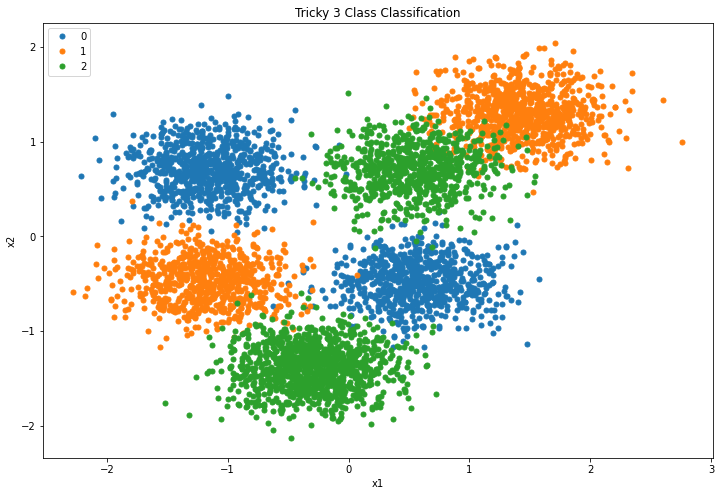

In [15]:
plot_data(X, y)

Now build your network. Good luck! 😉 

In [16]:
class Linear():
    def __init__(self, dim_in, dim_out, args = []):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.layer_type = "Linear"
        
        self.weight = np.random.rand(self.dim_out, self.dim_in)
        self.bias = np.random.rand(self.dim_out, 1)
        
        self.grad_w = np.zeros((self.dim_out, self.dim_in))
        self.grad_b = np.zeros((self.dim_out, 1))
        
    def apply(self, x):
        return np.dot(self.weight, x) + self.bias
    
    def backprop(self, grad, h_in, bsize):
        h_in_T = np.reshape(h_in, (1, len(h_in)))
        grad_w = np.dot(grad, h_in_T)
        grad_b = grad
        self.grad_w += 1.0/bsize * grad_w
        self.grad_b += 1.0/bsize * grad_b
        return np.dot(self.weight.T, grad)
    
    def update(self, lr, alpha):
        self.weight -= lr*self.grad_w - alpha*self.weight/np.linalg.norm(self.weight)
        self.bias -= lr*self.grad_b - alpha*self.bias/np.linalg.norm(self.bias)
        self.zero_grad()

    def zero_grad(self):
        self.grad_w = np.zeros((self.dim_out, self.dim_in))
        self.grad_b = np.zeros((self.dim_out, 1))
    
class ReLU():
    def __init__(self, dim_in, dim_out, args = []):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.layer_type = "ReLU"

    def apply(self, x):
        return np.maximum(0, x) 
    
    def backprop(self, grad, h_in, bsize):
        grad[np.where(h_in < 0)] = 0.0
        return grad
    
    def update(self, lr, alpha):
        pass

    def zero_grad(self):
        pass
    
class SoftMax():
    def __init__(self, dim_in, dim_out, args = []):
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.layer_type = "SoftMax"
        if (len(args) < 2):
            args = [-500.0, 500.0]
        self.min_clip = args[0]
        self.max_clip = args[1]
    
    def apply(self, out, y):
        out = np.clip(out, self.min_clip, self.max_clip)
        e_out = np.exp(out)
        log_sum = np.sum(e_out, axis = 0)
        label = int(y.item((0, 0)))
        logP = - e_out[label, :] + log_sum
        return logP
    
    def backprop(self, z, y):
        z = np.clip(z, self.min_clip, self.max_clip)
        e_z = np.exp(z)
        e_z = np.clip(e_z, self.min_clip, self.max_clip)
        grad = np.exp(z) / np.sum(np.exp(z))
        label = int(y.item((0, 0)))
        grad[label, :] -= 1.0
        return grad
            
    def likelihood(self, batch_out):
        batch_out = np.clip(batch_out, -500, 500)
        e_out = np.exp(batch_out)
        e_sum = np.sum(e_out, axis = 1)
        P = e_out / e_sum[:, np.newaxis, :]
        return P

In [17]:
class MLP():
    def __init__(self):
        self.layers = []
        self.inputs = []
        self.loss = None

    def __str__(self):
        out = []
        # Layers
        for L in self.layers:
            out.append(f'{L.layer_type} ({L.dim_in:d}, {L.dim_out:d})')

        # Loss
        if (self.loss is not None):
            out.append(f'Loss: {self.loss.layer_type} ({self.loss.dim_in:d}, {self.loss.dim_out:d})')

        return '\n'.join(out)
    
    def get_input_size(self):
        if (len(self.layers) > 0):
            return self.layers[0].dim_in
        else:
            return None

    def get_output_size(self):
        if (len(self.layers) > 0):
            return self.layers[-1].dim_out
        else:
            return None

    def add_layer(self, layer_type, dim_in, dim_out, args = []):
        if layer_type == 'Loss':
            self.loss = SoftMax(dim_in, dim_out, args)
        else:
            # Hidden or output layer
            # Add a ReLU if there are already layers before this one 
            if (len(self.layers) > 0):
                self.layers.append(ReLU(self.layers[-1].dim_out, dim_in))
            self.layers.append(Linear(dim_in, dim_out, args))
        
    def forward(self, batch_x, do_train = True):
        input_size = self.get_input_size()
        if input_size is None:
            return None

        self.inputs.append(batch_x)
        bsize = batch_x.shape[0]
        self.batch_out = np.zeros((bsize, self.get_output_size(), 1))
        
        if do_train:
            self.inputs = []
            for k in range(len(self.layers)):
                self.layers[k].zero_grad()
                self.inputs.append(np.zeros((bsize, self.layers[k].dim_in)))
        
        for idx in range(bsize):
            x = batch_x[idx, ::]
            x = x.reshape(input_size, 1)
            
            out = x
            for k in range(len(self.layers)):
                if do_train:
                    self.inputs[k][idx, ::] = np.reshape(out, np.shape(self.inputs[k][idx, ::]))
                out = self.layers[k].apply(out)
            out = out.reshape(self.get_output_size(), 1)
            self.batch_out[idx, ::] = out

        return self.batch_out
    
    def backward(self, batch_y):
        bsize = batch_y.shape[0]
        for idx in range(bsize):
            y = batch_y[idx, ::]
            y = y.reshape(1, 1)
            out = self.batch_out[idx, ::]
            out = out.reshape(self.get_output_size(), 1)
            
            grad = self.loss.backprop(out, y)
            for k in range(len(self.layers) - 1, -1, -1):
                h_in = self.inputs[k][idx, ::]
                grad = self.layers[k].backprop(grad, h_in, bsize)
    
    def predict(self, out):
        P = self.loss.likelihood(out)
        pred_labels = np.argmax(P, axis = 1)
        pred_labels = pred_labels.reshape(out.shape[0], 1)
        return pred_labels

    def train(self, data, labels, epochs = 10, bsize = 8, lr = 0.01, 
              alpha = 0.0, seed = None):
        
        if seed is not None:
            self.seed = seed
        else:
            self.seed = np.random.randint(1, 1000)
        np.random.seed(self.seed)
        
        n_train = data.shape[0]
        num_batches = int(n_train / (bsize + 1))
        train_idx = np.arange(data.shape[0])
        
        loss = np.zeros((epochs, 1))
        for epoch in range(epochs):
            np.random.shuffle(train_idx)
            for batch_idx in range(num_batches):
                idx = range(batch_idx*bsize, (batch_idx + 1)*bsize)
                batch_x = data[idx, ::]
                batch_y = labels[idx, ::]
                batch_out = self.forward(batch_x, do_train = True)
                
                batch_loss = 0.0
                for idx in range(bsize):
                    out = batch_out[idx, ::]
                    out = out.reshape(self.get_output_size(), 1)
                    y = batch_y[idx, ::]
                    y = y.reshape(1, 1)
                    batch_loss += self.loss.apply(out, y)

                batch_loss /= bsize
                loss[epoch, :] = batch_loss
                self.backward(batch_y)
                
                # Update batch
                for l in range(len(self.layers)):
                    self.layers[l].update(lr, alpha)
                
                self.inputs = []
                for l in range(len(self.layers)):
                    self.inputs.append(np.zeros((bsize, self.layers[l].dim_in)))

        return loss
    
    def test(self, data, labels):
        out = self.forward(data, do_train = False)
        test_n = labels.shape[0]
        pred_labels = self.predict(out)
        matches = np.sum(labels == pred_labels)
        return matches * 100.0 / test_n

In [18]:
def plot_loss(loss):
    idx = np.arange(loss.shape[0])
    fig, ax = plt.subplots(figsize = (12, 8))
    ax.plot(idx, loss, marker = 'o', linestyle = '-')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss during training")
    plt.show()

def plot_decision_regions(NN):
    # Axis
    n = 300
    idx = np.linspace(-2.5, 2.5, n)

    # Create a grid
    x1, x2 = np.meshgrid(idx, idx)
    X = np.zeros((n*n, 2))
    X[:, 0] = x1.flatten()
    X[:, 1] = x2.flatten()

    # Run the network on each point in the grid
    out = NN.forward(X, do_train = False)
    y_prob = NN.predict(out)

    # Plot the results
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05)

    for y_val in [0, 1, 2]:
        ind = [k for k in range(0, X.shape[0]) if y_prob[k] == y_val]
        ax.plot(X[ind, 0], X[ind, 1], 
                f'C{y_val:d}', marker='o', linestyle='', ms=5, label=f'{y_val:d}')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Decision boundary')
    plt.show()

def generate_data(rmin, rmax, points):
    idx = np.linspace(rmin, rmax, points)
    x1, x2 = np.meshgrid(idx, idx)
    new_x = np.zeros((points * points, 2))
    new_x[:, 0] = x1.flatten()
    new_x[:, 1] = x2.flatten()
    return new_x

# Function for splitting data into training and testing sets
def split_data(X, y, batch_size = 8, validation_split = 0.1, test_split = 0.2):
    # Compute the size of the training set
    n = X.shape[0]
    test_n = int((test_split * n) // 1)
    valid_n = int((test_split * n) // 1)

    # Generate the indices for the test and training sets
    test_idx = np.random.choice(np.arange(n), test_n, replace = False)
    remain_idx = [x for x in np.arange(n) if x not in test_idx]
    valid_idx = np.random.choice(remain_idx, valid_n, replace = False)
    train_idx = [x for x in remain_idx if x not in valid_idx]

    # Return the training, validation, and test data
    train_X, train_y = X[train_idx, ::], y[train_idx, ::]
    valid_X, valid_y = X[valid_idx, ::], y[valid_idx, ::]
    test_X, test_y = X[test_idx, ::], y[test_idx, ::]
    return train_X, train_y, valid_X, valid_y, test_X, test_y

--- 3 hidden unit(s), 1 hidden layer(s), α = 0.000 ---
Linear (2, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
Loss: SoftMax (3, 3)


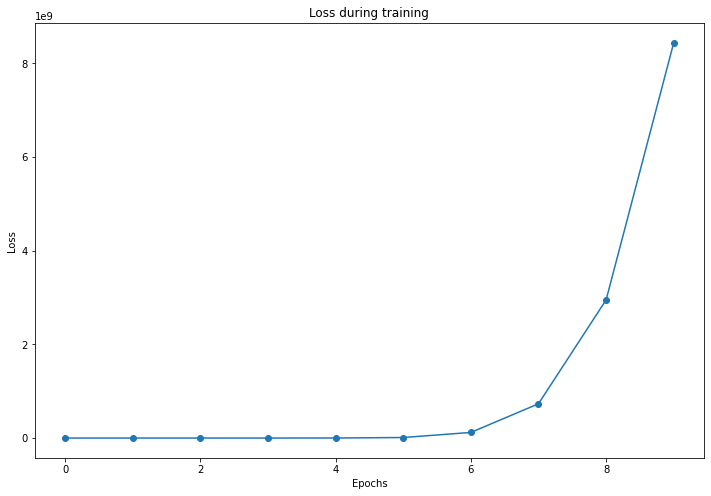

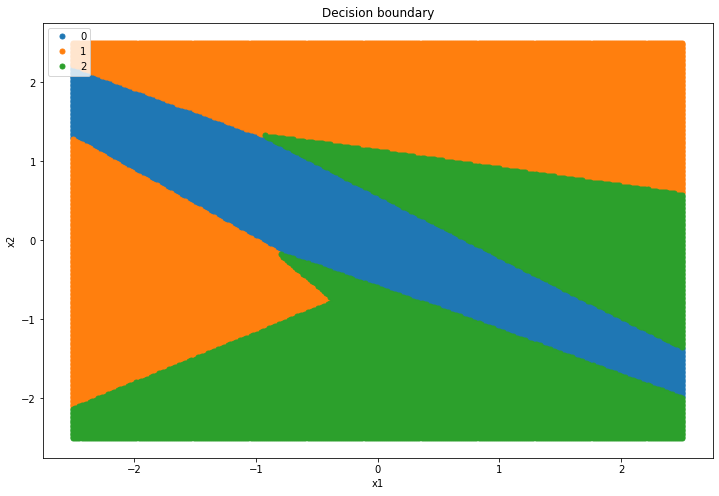

--- 3 hidden unit(s), 1 hidden layer(s), α = 0.001 ---
Linear (2, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
Loss: SoftMax (3, 3)


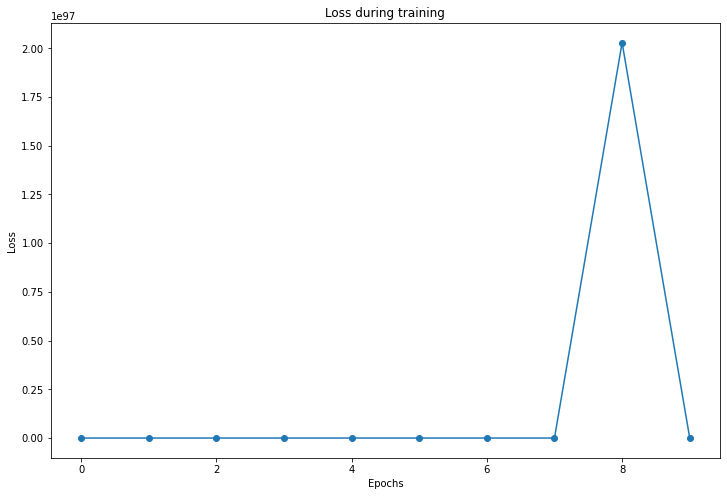

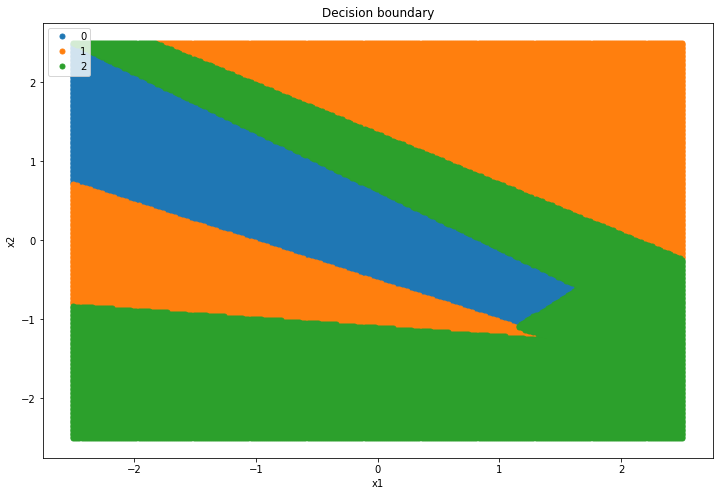

--- 3 hidden unit(s), 3 hidden layer(s), α = 0.000 ---
Linear (2, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
Loss: SoftMax (3, 3)


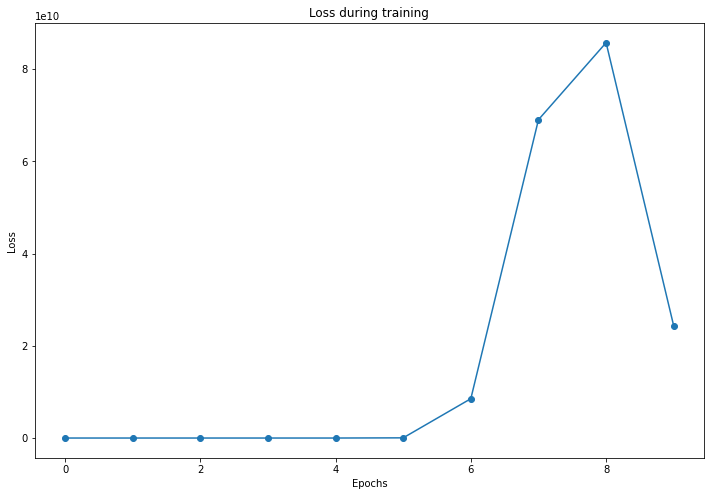

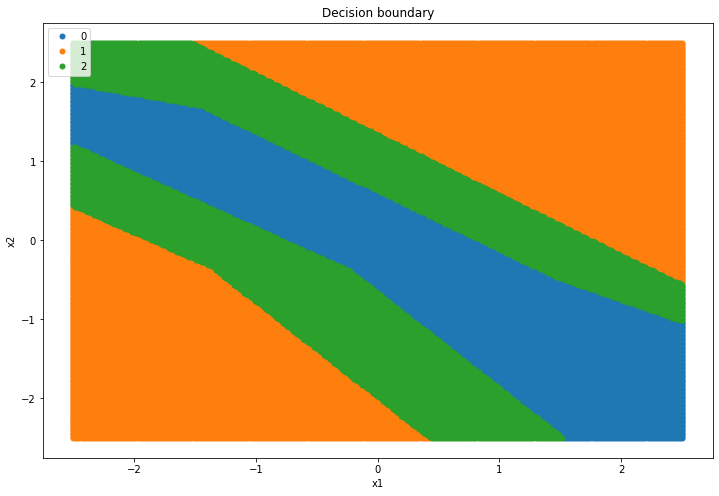

--- 3 hidden unit(s), 3 hidden layer(s), α = 0.001 ---
Linear (2, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
ReLU (3, 3)
Linear (3, 3)
Loss: SoftMax (3, 3)


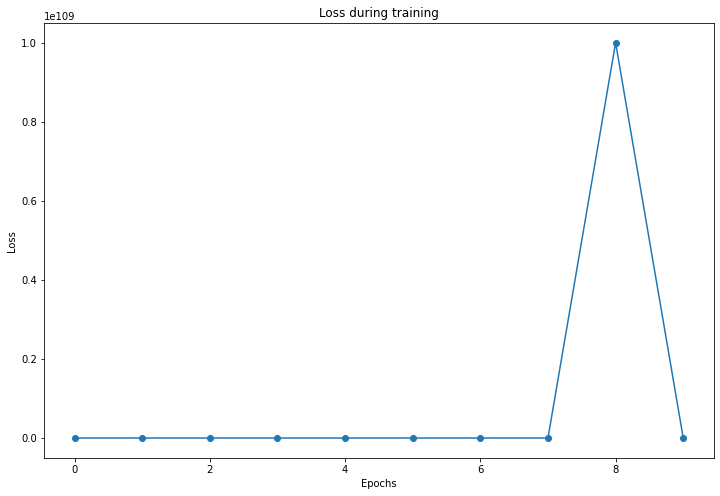

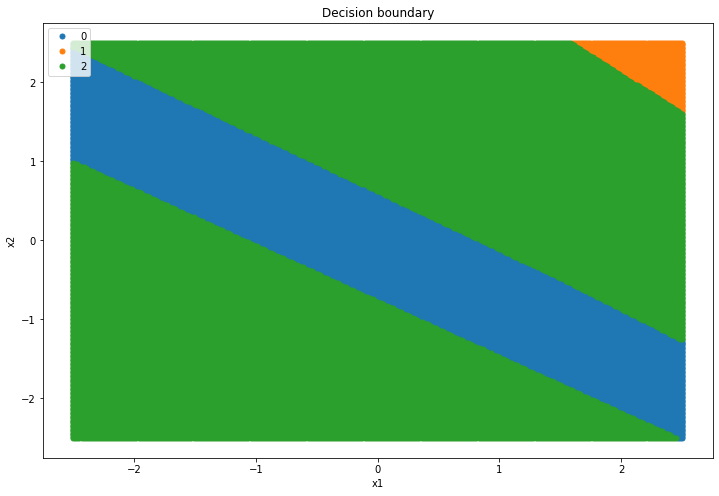

--- 8 hidden unit(s), 1 hidden layer(s), α = 0.000 ---
Linear (2, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 3)
Loss: SoftMax (3, 3)


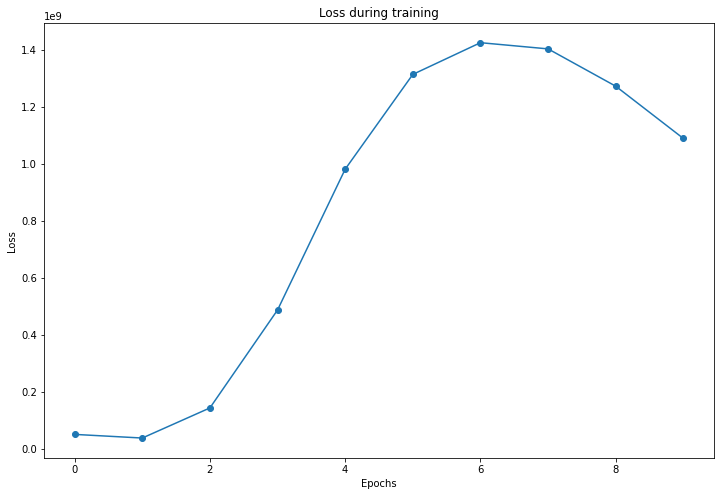

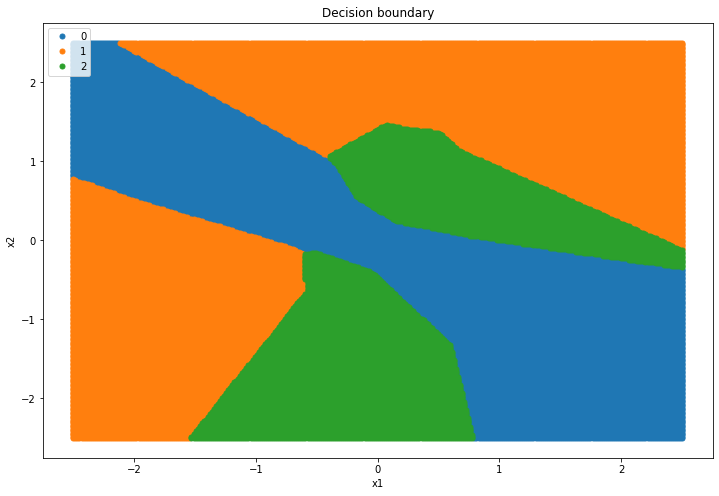

--- 8 hidden unit(s), 1 hidden layer(s), α = 0.001 ---
Linear (2, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 3)
Loss: SoftMax (3, 3)


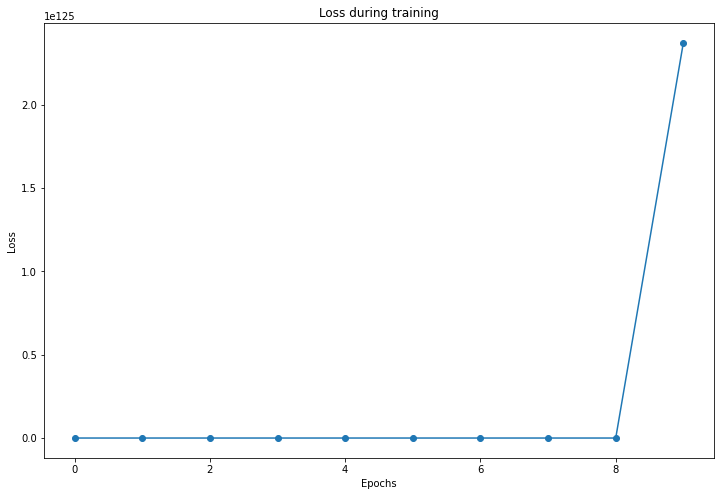

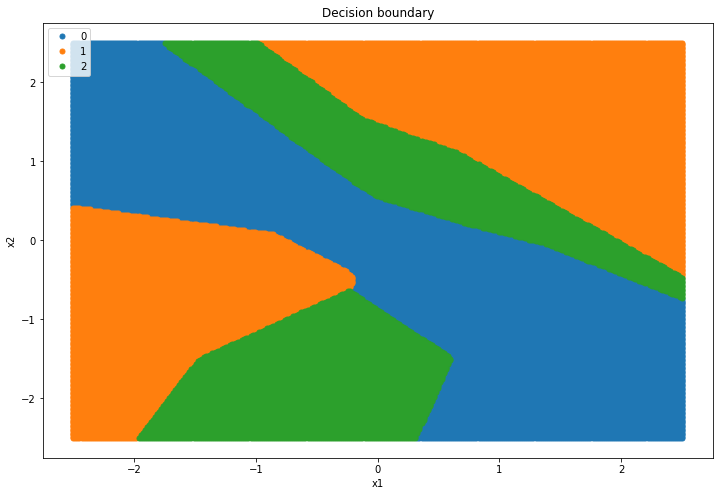

--- 8 hidden unit(s), 3 hidden layer(s), α = 0.000 ---
Linear (2, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 3)
Loss: SoftMax (3, 3)


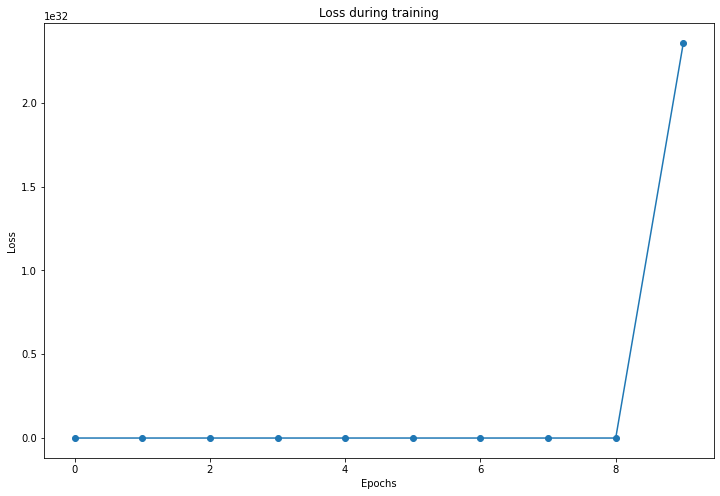

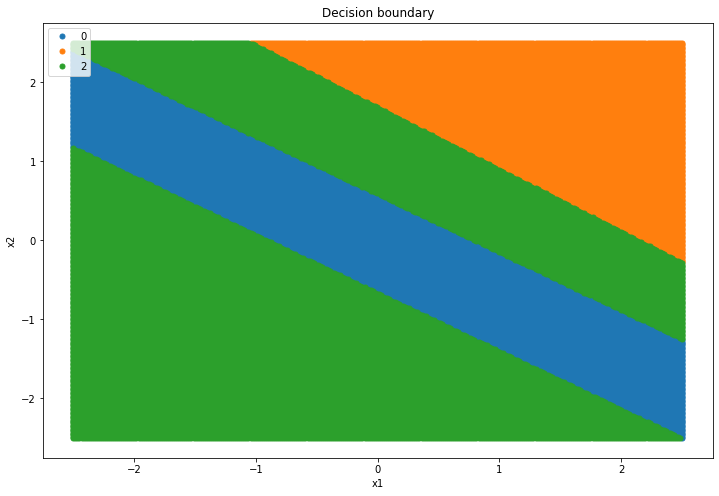

--- 8 hidden unit(s), 3 hidden layer(s), α = 0.001 ---
Linear (2, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 8)
ReLU (8, 8)
Linear (8, 3)
Loss: SoftMax (3, 3)


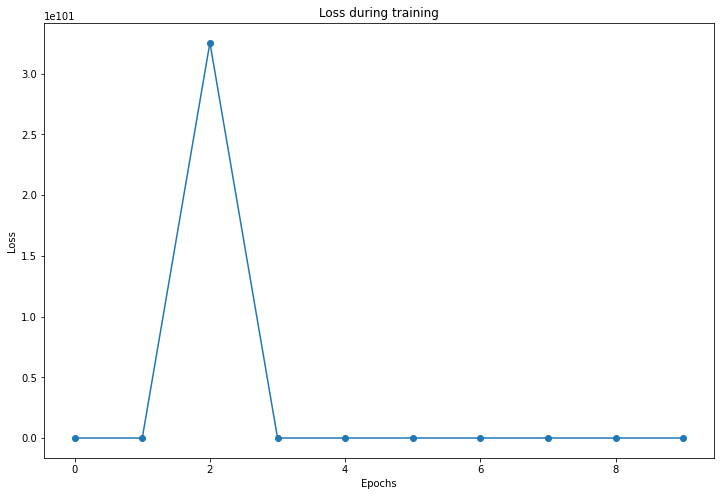

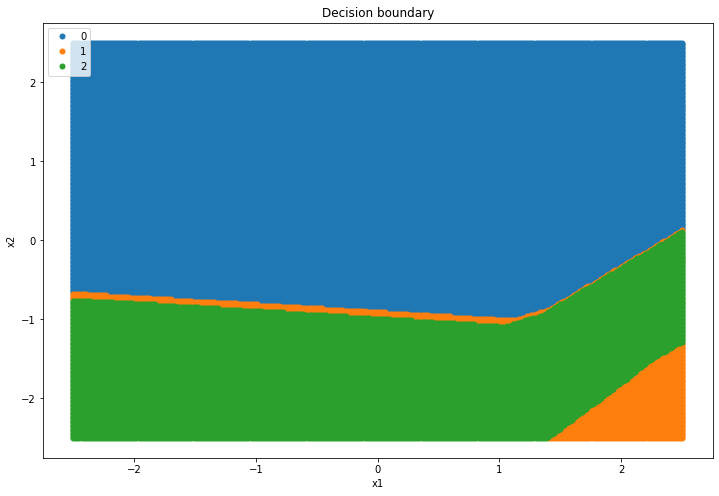

--- 16 hidden unit(s), 1 hidden layer(s), α = 0.000 ---
Linear (2, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 3)
Loss: SoftMax (3, 3)


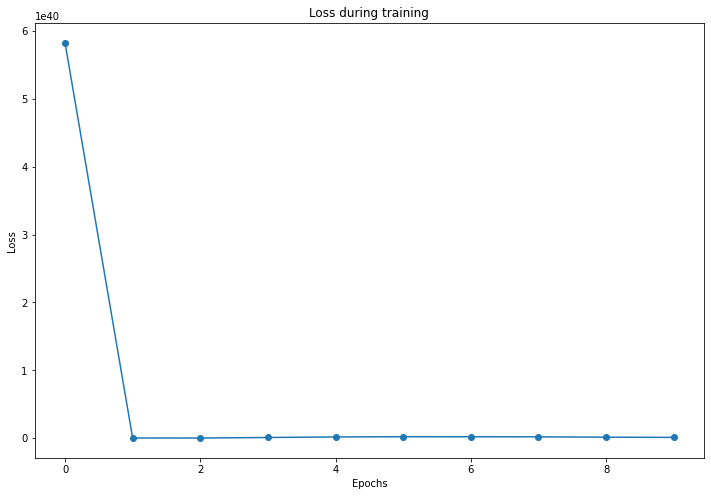

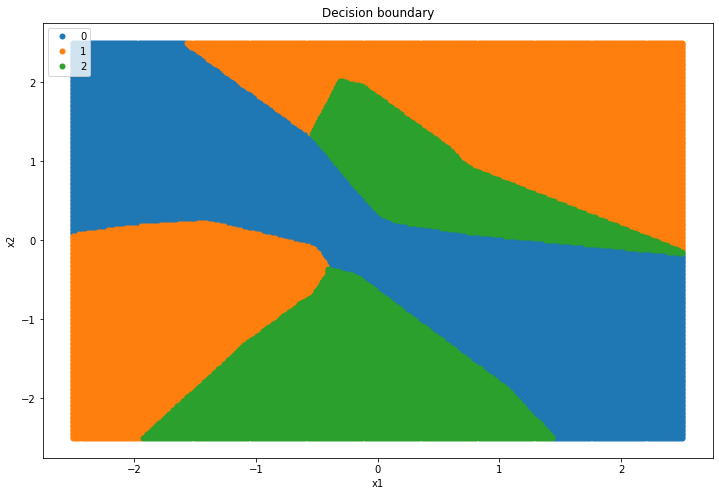

--- 16 hidden unit(s), 1 hidden layer(s), α = 0.001 ---
Linear (2, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 3)
Loss: SoftMax (3, 3)


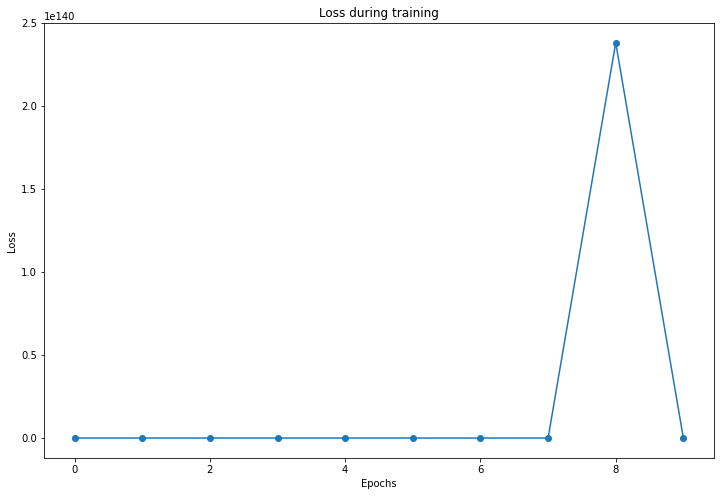

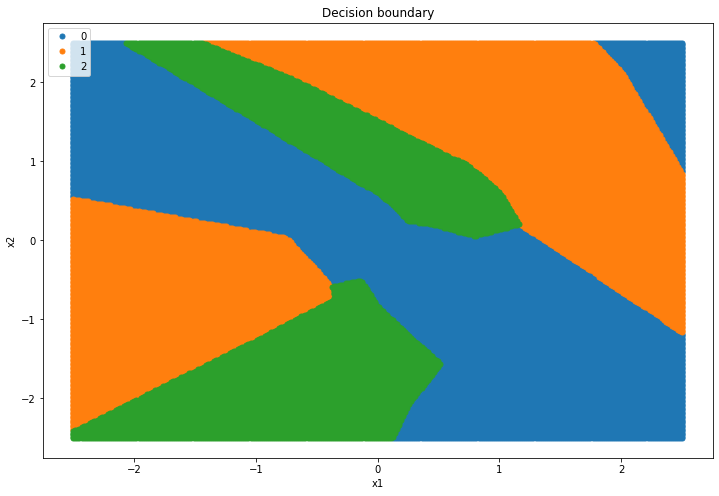

--- 16 hidden unit(s), 3 hidden layer(s), α = 0.000 ---
Linear (2, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 3)
Loss: SoftMax (3, 3)


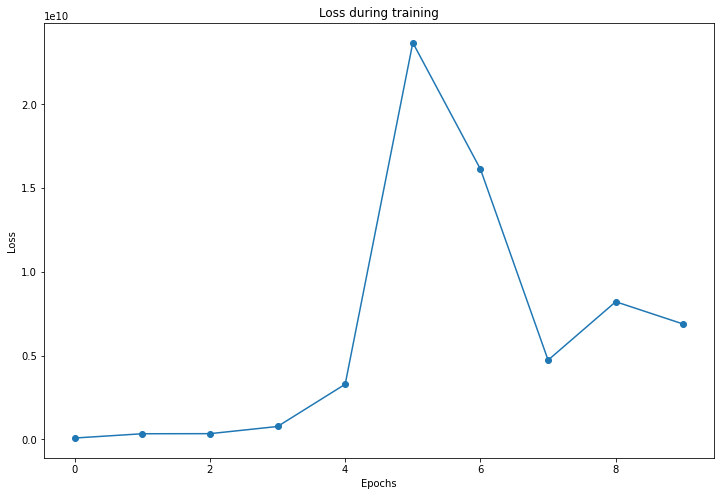

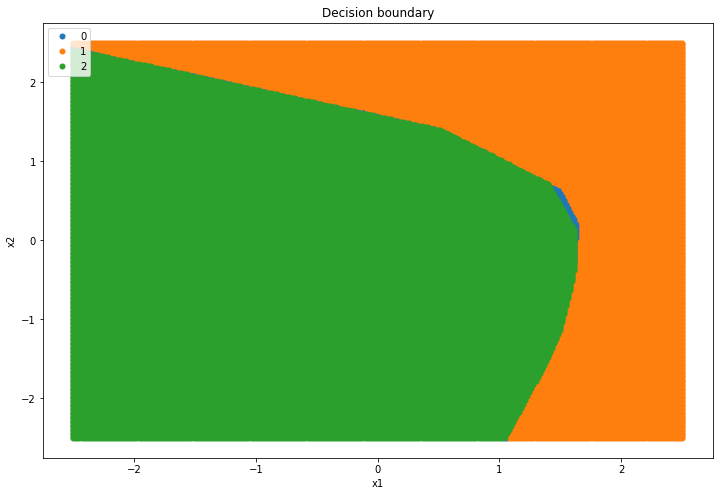

--- 16 hidden unit(s), 3 hidden layer(s), α = 0.001 ---
Linear (2, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 3)
Loss: SoftMax (3, 3)


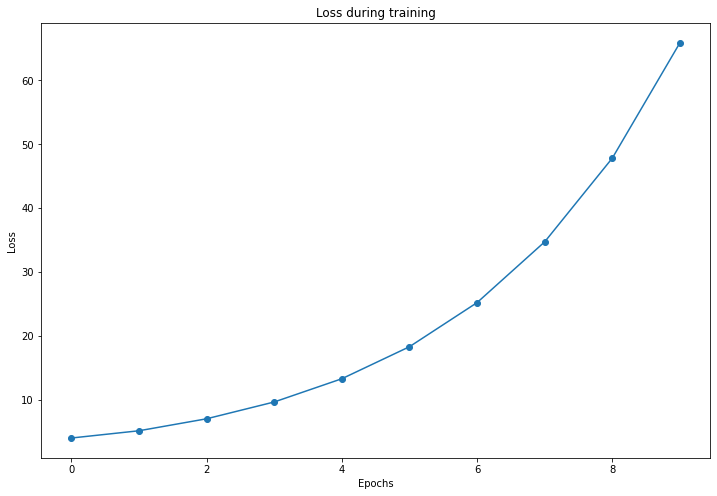

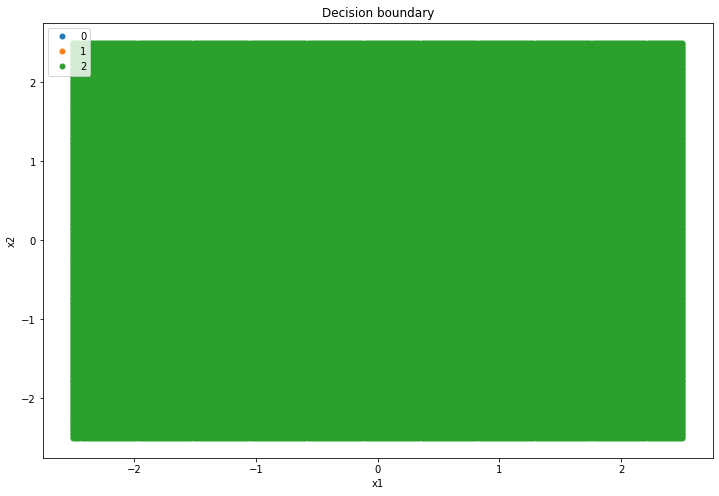

In [19]:
# Parts A, B, and C
hidden_units = [3, 8, 16]
hidden_layers = [1, 3]
alpha_values = [0, 0.001]

for hu in hidden_units:
    for hl in hidden_layers:
        for alpha_value in alpha_values:
            # Initialize network
            NN = MLP()

            # Input layer
            NN.add_layer('Hidden', dim_in=2, dim_out=hu)

            # Hidden layers
            for k in range(hl):
                NN.add_layer('Hidden', dim_in=hu, dim_out=hu)
            
            # Output layer
            NN.add_layer('Output', dim_in=hu, dim_out=3)

            # Loss
            NN.add_layer('Loss', dim_in=3, dim_out=3)

            # Output model
            print(f'--- {hu:d} hidden unit(s), {hl:d} hidden layer(s), \u03B1 = {alpha_value:.3f} ---')
            print(NN)

            # Train and compute loss
            loss = NN.train(X, y, epochs=10, bsize=8, alpha=alpha_value)
            plot_loss(loss)

            # Plot decision regions
            plot_decision_regions(NN)

Linear (2, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 16)
ReLU (16, 16)
Linear (16, 3)
Loss: SoftMax (3, 3)
Epoch 1: validation accuracy 22.8%
Epoch 2: validation accuracy 46.7%
Epoch 3: validation accuracy 46.7%
Epoch 4: validation accuracy 46.7%
Epoch 5: validation accuracy 46.7%
Epoch 6: validation accuracy 46.7%
Epoch 7: validation accuracy 46.7%
Epoch 8: validation accuracy 50.0%
Epoch 9: validation accuracy 58.7%
Epoch 10: validation accuracy 65.2%
Epoch 11: validation accuracy 69.6%
Epoch 12: validation accuracy 71.7%
Epoch 13: validation accuracy 70.7%
Epoch 14: validation accuracy 70.7%
Test accuracy: 71.7%


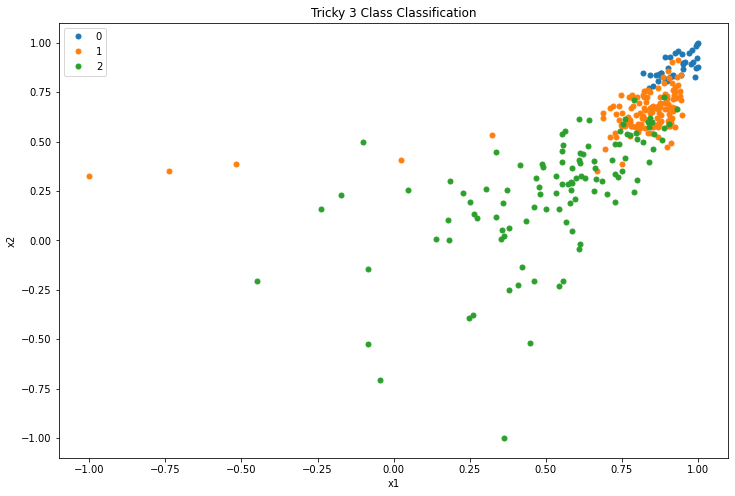

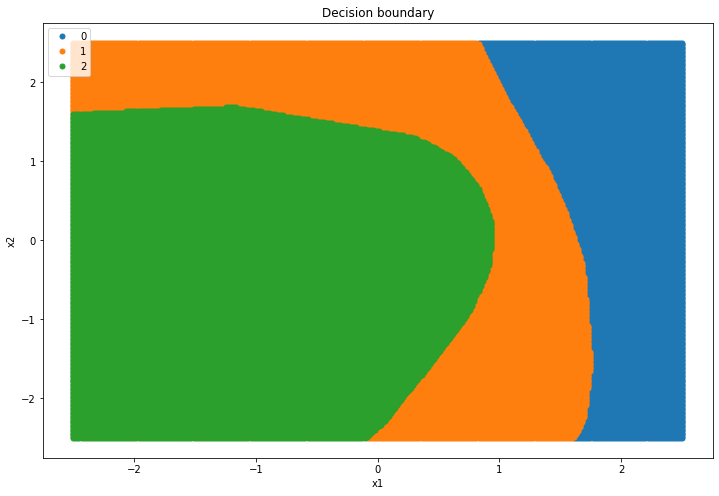

In [21]:
# Part D

# Import data
dataHW = pd.read_csv('DateFruit.csv')

# Keep only a multiple of the batch size
n_drop = len(dataHW) % 8
dataHW.drop(dataHW.tail(n_drop).index, inplace = True)

# Normalize
for k in [0, 1]:
    dataHW.iloc[:,k] = dataHW.iloc[:,k]  / dataHW.iloc[:,k] .abs().max()

# set X (training data) and y (target variable)
cols = dataHW.shape[1]
XHW = dataHW.iloc[:,0:(cols-1)]
yHW = dataHW.iloc[:,(cols-1):cols]

# Convert to numpy matrices
XHW = np.matrix(XHW.values)
yHW = np.matrix(yHW.values)

# Split the data
train_X, train_y, valid_X, valid_y, test_X, test_y = split_data(XHW, yHW)

# Build network
hidden_units = 16
hidden_layers = 2
NN = MLP()

# Input layer
NN.add_layer('Hidden', dim_in=(cols-1), dim_out=hidden_units)

# Hidden layers
for k in range(hidden_layers):
    NN.add_layer('Hidden', dim_in=hidden_units, dim_out=hidden_units)

# Output layer
NN.add_layer('Output', dim_in=hidden_units, dim_out=3)

# Loss
NN.add_layer('Loss', dim_in=3, dim_out=3)

# Output model
print(NN)

# Train and validate
min_epochs = 10
acc_diff_threshold = 0.01
acc_diff = acc_diff_threshold + 1
prev_acc = 0.0
epoch = 0
while (acc_diff > acc_diff_threshold) or (epoch < min_epochs):
    loss = NN.train(train_X, train_y, epochs=1, bsize=8, alpha=0.001)
    current_acc = NN.test(valid_X, valid_y)
    acc_diff = np.abs(current_acc - prev_acc)
    epoch += 1
    print(f'Epoch {epoch:d}: validation accuracy {current_acc:.1f}%')
    prev_acc = current_acc

# Test
print(f'Test accuracy: {NN.test(test_X, test_y):.1f}%')

# Plot the data
plot_data(train_X, train_y)

# Plot decision regions
plot_decision_regions(NN)

Fruit dataset can be found at https://drive.google.com/drive/folders/1naOUAho1ljebBS9WyzZoi2V7S4tp8Gaw?usp=sharing